# Genetic Programming

In the lecture, we talked about genetic programming. Today we will try it out by practicing it on the problem of symbolic regression (i.e., finding a formula that fits the given data) and classification, i.e., finding a decision tree using genetic programming. We will use the `deap` library, which we briefly demonstrated last time.

We will start by importing and generating the data we will use for the regression.

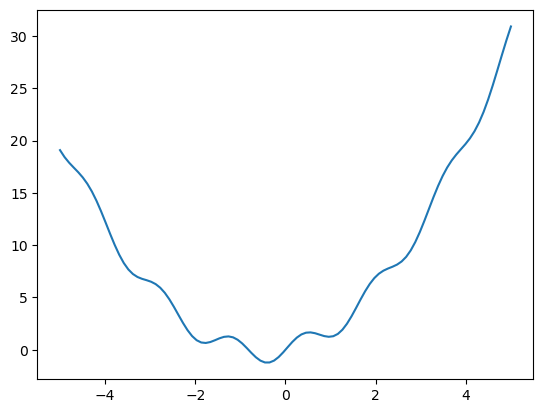

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x_train = np.linspace(-5, 5, 100)
y_train = x_train*x_train + x_train + np.sin(4*x_train)

plt.plot(x_train, y_train)
plt.show()

Let's prepare a helper function to display the created tree. This uses the pydot library (and the GraphViz program) to draw graphs. If you install pydot using `conda`, it graphviz should be installed automatically.

In [2]:
import pydot
from IPython.display import Image

# display the individual as a tree
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type='graph')
    for node in nodesDot:
        g.add_node(node)
    for f,t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

When working with genetic programming, we need to create a set of primitives - terminals and non-terminals that evolution will work with. There is a class `gp.PrimitiveSet` in `deap` for this, or `gp.PrimitiveSetTyped` for typed GPs. We'll show the typed case here because it's more general. But we'll only use one type, so there's actually no need.

In [3]:
import operator

from deap import gp

pset = gp.PrimitiveSetTyped('MAIN', [float], float) # the name of the set is MAIN, there is one float input and one float output
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)
pset.addPrimitive(np.sin, [float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)

In [4]:
from deap import creator, base, tools, algorithms

#define fitness - it computes the MSE and individual size, the weights are set below to (-1.0 a -0.01)
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # compile can be used to transform the individual into a function callable in Python
    vals = list(map(func, x))
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

#set up the algorithm
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#limit the depth of the tree
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [5]:
pop = toolbox.population(n=100)
#save the best solution
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max  	min   	nevals	std    	avg  	gen	max	min	nevals	std    
0  	100   	354.204	0  	10741	35.419	100   	1284.75	57.68	0  	456	4  	100   	86.5101
1  	62    	128.467	1  	1564.91	78.4908	62    	145.557	35.89	1  	425	2  	62    	62.786 
2  	58    	103.905	2  	127.743	77.8172	58    	14.2836	19.38	2  	118	2  	58    	19.3922
3  	51    	93.3899	3  	170.42 	76.3666	51    	14.0315	18.54	3  	45 	2  	51    	10.8346
4  	71    	86.7316	4  	132.387	50.2397	71    	12.2018	16.89	4  	46 	3  	71    	7.50053
5  	64    	88.1512	5  	471.002	47.3862	64    	42.5907	18.13	5  	46 	8  	64    	6.70918
6  	56    	79.2264	6  	291.347	29.8517	56    	25.8294	18.7 	6  	44 	3  	56    	5.54707
7  	53    	71.3908	7  	143.756	29.8517	53    	19.1219	19.28	7  	39 	3  	53    	6.27548
8  	54   

Let us show the best individual at the end of evolution.

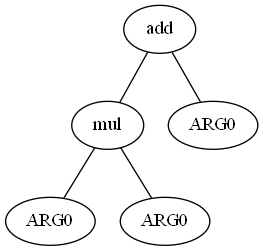

In [6]:
Image(plot_tree(hof[0]))

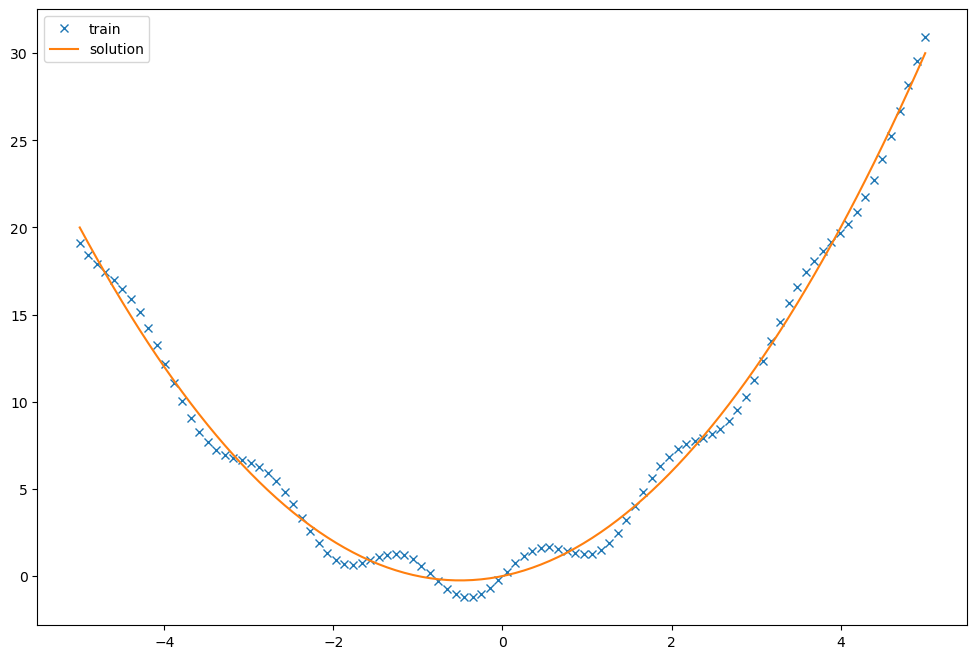

In [7]:
# compare the function we found with the training data
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, 'x', label='train')
plt.plot(x_train, y, label='solution')
plt.legend()
plt.show()

## Exercise

Try using genetic programming to solve the classification problem, e.g. for a dataset with irises. Think about how to define a set of primitives and fitness. Implement and run the algorithm.

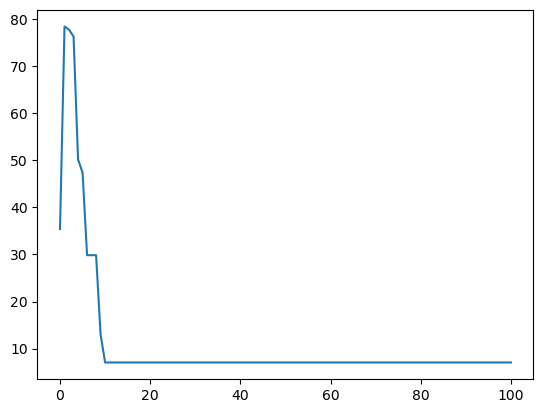

In [8]:
plt.plot([l['min'] for l in log.chapters['fitness']])